In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Input, Dropout
import re
import joblib

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
train_file_path = '/content/drive/My Drive/archive drug/drugsComTrain_raw.csv'
test_file_path = '/content/drive/My Drive/archive drug/drugsComTest_raw.csv'
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)
df = pd.concat([train_data, test_data])

In [ ]:
# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
df['condition'] = label_encoder.fit_transform(df['condition'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['condition'], test_size=0.2, random_state=42)

In [ ]:
# TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)



In [ ]:
# Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv = count_vectorizer.transform(X_test)



In [ ]:
# Combine features
X_train_combined = hstack([X_train_tfidf, X_train_cv]).toarray()
X_test_combined = hstack([X_test_tfidf, X_test_cv]).toarray()

In [ ]:
# Define the CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape[1], 1)))
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    return model



In [ ]:
# Reshape the data for CNN
X_train_combined = X_train_combined.reshape((X_train_combined.shape[0], X_train_combined.shape[1], 1))
X_test_combined = X_test_combined.reshape((X_test_combined.shape[0], X_test_combined.shape[1], 1))



In [ ]:
# Create and compile the model
cnn_model = create_cnn_model(X_train_combined.shape)
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
cnn_model.fit(X_train_combined, y_train, epochs=5, batch_size=32, validation_data=(X_test_combined, y_test))

Epoch 1/5
5377/5377 [==============================] - 1918s 357ms/step - loss: 2.5707 - accuracy: 0.4977 - val_loss: 1.8029 - val_accuracy: 0.6167
Epoch 2/5
5377/5377 [==============================] - 1916s 356ms/step - loss: 1.9384 - accuracy: 0.5827 - val_loss: 1.6562 - val_accuracy: 0.6389
Epoch 3/5
5377/5377 [==============================] - 1902s 354ms/step - loss: 1.7255 - accuracy: 0.6148 - val_loss: 1.5563 - val_accuracy: 0.6594
Epoch 4/5
5377/5377 [==============================] - 1902s 354ms/step - loss: 1.5627 - accuracy: 0.6402 - val_loss: 1.5026 - val_accuracy: 0.6733
Epoch 5/5
5377/5377 [==============================] - 1900s 353ms/step - loss: 1.4369 - accuracy: 0.6625 - val_loss: 1.4509 - val_accuracy: 0.6851


In [ ]:
def predict_condition(review, model, tfidf_vectorizer, count_vectorizer, label_encoder):
    # review = preprocess_text(review)
    review_tfidf = tfidf_vectorizer.transform([review])
    review_cv = count_vectorizer.transform([review])
    review_combined = hstack([review_tfidf, review_cv])
    prediction = model.predict(review_combined.toarray())
    predicted_condition = label_encoder.inverse_transform(np.argmax(prediction, axis=1))[0]
    return predicted_condition


In [ ]:
from sklearn.metrics import mean_absolute_error

# Predict the conditions for the test set
y_test_pred_prob = cnn_model.predict(X_test_combined)
y_test_pred = np.argmax(y_test_pred_prob, axis=1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Mean Absolute Error: {mae}')

1345/1345 [==============================] - 96s 71ms/step
Mean Absolute Error: 82.64027154581173


In [ ]:
import numpy as np

def predict_condition(review, model, tfidf_vectorizer, label_encoder):
    # Convert the review to a TF-IDF representation
    tfidf_input = tfidf_vectorizer.transform([review])

    # Convert the TF-IDF representation to a dense array
    cnn_input = tfidf_input.toarray()

    # If the model expects a specific input size, reshape the input to match that
    # For example, if the CNN model expects an input of shape (None, sequence_length, channels)
    # Replace 'expected_input_shape' with the actual input shape (e.g., 159808)
    expected_input_shape = model.input_shape[1]  # This should be (sequence_length, channels)

    if cnn_input.shape[1] != expected_input_shape:
        # Handle the mismatch (e.g., trim or pad the input)
        if cnn_input.shape[1] > expected_input_shape:
            cnn_input = cnn_input[:, :expected_input_shape]
        else:
            padding = np.zeros((cnn_input.shape[0], expected_input_shape - cnn_input.shape[1]))
            cnn_input = np.hstack((cnn_input, padding))

    # Reshape the input to match the model's expected input dimensions
    cnn_input = cnn_input.reshape((cnn_input.shape[0], expected_input_shape, 1))

    # Make predictions using the model
    prediction = model.predict(cnn_input)

    # Get the index of the highest probability class
    predicted_index = np.argmax(prediction, axis=1)

    # Decode the index to get the predicted condition
    predicted_condition = label_encoder.inverse_transform(predicted_index)

    return predicted_condition[0]

# Example usage
new_review = input("Enter a review: ")
predicted_condition = predict_condition(new_review, cnn_model, tfidf_vectorizer, label_encoder)
print(f'The predicted condition is: {predicted_condition}')


Enter a review: "I was taking regular Trazodone on and off for a couple of years, it stopped working so my doctor switched me to Desyrel. It&#039;s a good pill for the fact that it does make you tired, but I&#039;d make sure you&#039;re gonna get 8 or more hours of sleep before you take it. I was prescribed 100mg pills, and I only took half of a pill whenever I took it, and I had the hardest time waking up the next day. Also, with the reg Trazodone and with Desyrel, it took a long time for it to kick in for me (2  hours), but that might be because I have a high tolerance to pills. If you&#039;re new to this medicine, take it on the weekend, or whenever you can sleep in, so you can see how it works."
1/1 [==============================] - 0s 42ms/step
The predicted condition is: Insomnia


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_test_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.6851417013461046


In [ ]:
from sklearn.metrics import classification_report

# Get the unique classes in y_test
unique_classes = np.unique(y_test)

# Ensure target names are strings
target_names = [str(label) for label in label_encoder.inverse_transform(unique_classes)]

report = classification_report(y_test, y_test_pred, labels=unique_classes, target_names=target_names)
print(f'Classification Report:\n{report}')

Classification Report:
                                                                     precision    recall  f1-score   support

                         0</span> users found this comment helpful.       0.00      0.00      0.00        27
                        10</span> users found this comment helpful.       0.00      0.00      0.00         6
                        11</span> users found this comment helpful.       0.00      0.00      0.00         6
                        12</span> users found this comment helpful.       0.00      0.00      0.00         6
                        13</span> users found this comment helpful.       0.00      0.00      0.00         6
                        14</span> users found this comment helpful.       0.00      0.00      0.00         2
                        15</span> users found this comment helpful.       0.00      0.00      0.00         5
                        16</span> users found this comment helpful.       0.00      0.00      0.00      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize the output for ROC curve computation
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize # Import label_binarize from the correct module

# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))

# ... rest of your code ...

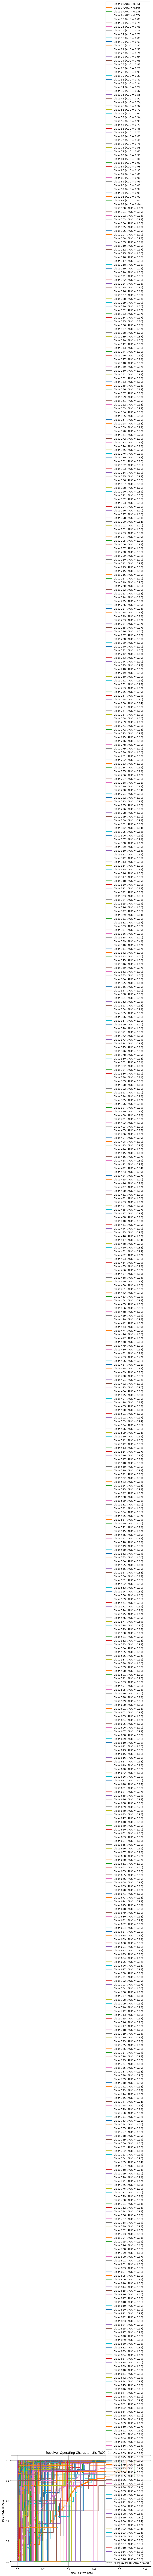

In [ ]:

# Identify classes with positive samples
valid_classes = [i for i in range(len(label_encoder.classes_)) if np.sum(y_test_bin[:, i]) > 0]

# Initialize dictionaries to store ROC metrics
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC Curve and AUC for each valid class
for i in valid_classes:
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_pred_prob[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_test_pred_prob[:, i])

# Compute micro-average ROC curve and ROC area
y_test_bin_valid = y_test_bin[:, valid_classes]
y_test_pred_prob_valid = y_test_pred_prob[:, valid_classes]
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin_valid.ravel(), y_test_pred_prob_valid.ravel())
roc_auc["micro"] = roc_auc_score(y_test_bin_valid, y_test_pred_prob_valid, average='micro')

# Plot ROC Curve
plt.figure(figsize=(10, 8))

# Plot ROC curve for each valid class
for i in valid_classes:
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

In [ ]:
# Predictions on the test data
y_pred_prob = cnn_model.predict(X_test_combined)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

1345/1345 [==============================] - 96s 71ms/step


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6851


In [ ]:
# Precision, Recall, F1-Score (weighted)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f'Precision (Weighted): {precision:.4f}')
print(f'Recall (Weighted): {recall:.4f}')
print(f'F1 Score (Weighted): {f1:.4f}')

Precision (Weighted): 0.6732
Recall (Weighted): 0.6851
F1 Score (Weighted): 0.6466


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import joblib

# Save the vectorizers and label encoder
joblib.dump(tfidf_vectorizer, '/content/drive/My Drive/drug/tfidf_vectorizer_condition.pkl')
joblib.dump(count_vectorizer, '/content/drive/My Drive/drug/count_vectorizer_condition.pkl')
joblib.dump(label_encoder, '/content/drive/My Drive/drug/label_encoder_condition.pkl')

# Save the trained model
cnn_model.save('/content/drive/My Drive/drug/condition_prediction.h5')